In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

In [2]:
from nca.utils import conv_same

In [3]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight", pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [4]:
def gif_from_pils(pils, fps):
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [5]:
def make_gif(nca_out, fps=10, size=(500, 500)):
    nca_out = torch.pow(nca_out, 1)
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize(size, Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [35]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 32
        hid = 8

        self.seed = nn.Parameter(torch.randn(64, 64) / 10, requires_grad=True)
        self.kernel = nn.Sequential(
            conv_same(1, perc, ks=3, padding_mode="zeros"),
            nn.LeakyReLU(),
            conv_same(perc, perc, ks=3, padding_mode="zeros"),
            nn.LeakyReLU(),
        )
        self.rule = nn.Sequential(
            conv_same(perc, 1, ks=1, bias=False),
        )

#         for p in self.kernel.parameters():
#             nn.init.normal_(p, 0, 1)
#         for p in list(self.rule.parameters()):
#             nn.init.uniform_(p, -0.02, 0.02)

    def forward(self, x, steps):
        x += self.seed
        seq = [x]
        for i in range(steps):
            perc = self.kernel(x)
            y = self.rule(perc)
            x = torch.clip(x + y, 0, 1)
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [36]:
nca = SimpleNCA()

In [37]:
inp = torch.randn(3, 1, 64, 64)

In [38]:
out = nca(inp, steps=50)
out.shape

torch.Size([3, 51, 1, 64, 64])


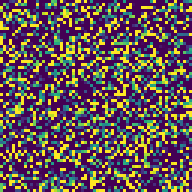

In [39]:
make_gif(out[1,:,0], size=(64 * 3, 64 * 3))

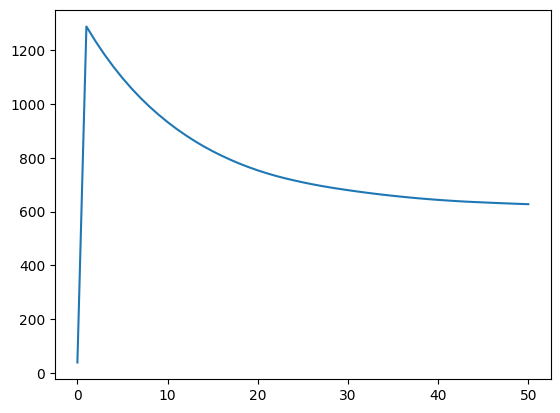

In [40]:
single = out[1,:,0]
vals = single.reshape(single.shape[0], -1).sum(axis=1)
vals = vals.detach().cpu().numpy()
plt.plot(vals)

In [41]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchdata.datapipes.iter import IterableWrapper

In [42]:
ds = MNIST(root="./.data", download=True, transform=ToTensor())

In [43]:
bs = 64
num_classes = 10
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)

/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/graph_settings.py:90: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [44]:
batch = next(iter(dl))

In [45]:
def sample_random_input(dl):
    it = iter(dl)
    while True:
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(dl)
        bs, _, H, W = x.shape
        ws = 64
        s = x.shape[-1]
        screen = torch.zeros(bs, 1, ws, ws)
        f = ws//2 - s//2
        screen[:, :, f:f+s, f:f+s] = x
        yield screen, y

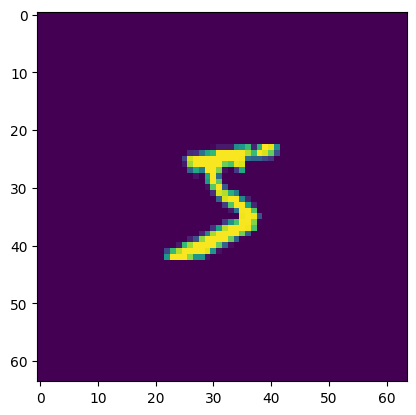

In [46]:
gen = sample_random_input(dl)
batch = next(gen)
im = batch[0][0,0]
plt.imshow(im)

In [47]:
out = nca(batch[0], steps=40)

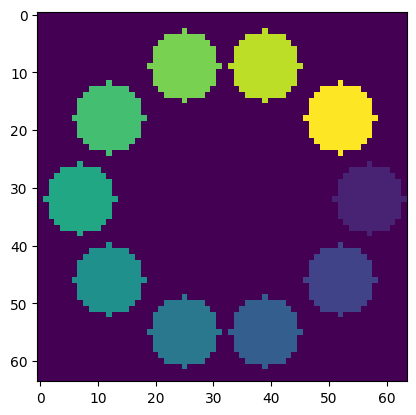

In [48]:
import cv2

S = 64
screen = np.zeros((S, S))

for i, tau in enumerate(np.linspace(0, np.pi * 2, num_classes, endpoint=False)):
    sr = 6
    r = 25
    cv2.circle(screen, [S // 2 + int(np.cos(tau) * r),  S // 2 + int(np.sin(tau) * r)], sr, i + 1, thickness=-1)

plt.imshow(screen)

In [49]:
np.unique(screen)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


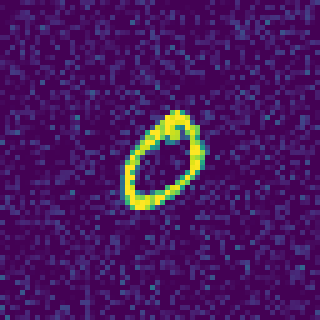

In [50]:
make_gif(out[1,:,0], size=(64 * 5, 64 * 5))

In [51]:
sums = out.reshape(*out.shape[:2], -1).mean(axis=2)

In [52]:
np.unique(screen)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [53]:
def optim_step(nca, batch, optim, device):
    x, y = batch
    x = x.to(device)  # [B, W, H]
    y = y.to(device)  # [B]
    out = nca(x, steps=50)  # [B, T, W, H]
    last = 20
    clf_out = torch.stack([
        out[:, -last:,0].mean(axis=1)[:, screen == s + 1].mean(axis=1)
        for s in range(len(np.unique(screen)) - 1)
    ], axis=1).softmax(axis=1)
    
    loss = F.cross_entropy(clf_out, y)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss

In [54]:
from copy import deepcopy

In [55]:
lr = 0.0001
target_nca = deepcopy(nca)
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)
history = []

In [56]:
device = "cuda"
target_nca = target_nca.to(device)

Loss: 2.3025848866:  28%|##7       | 2800/10001 [07:56<19:44,  6.08it/s]

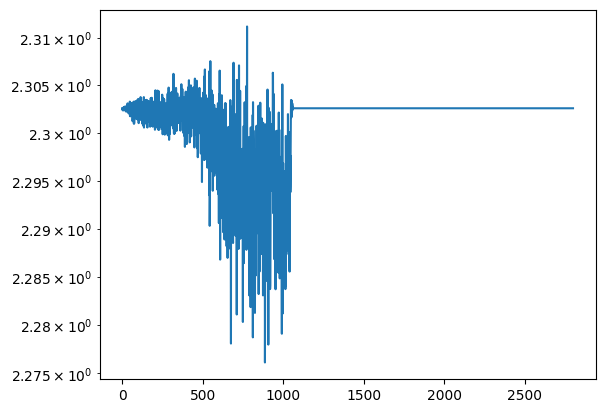


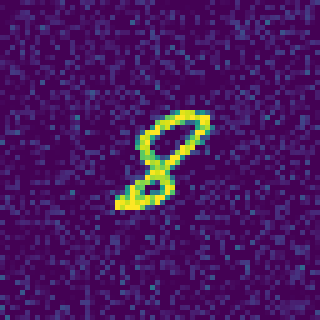


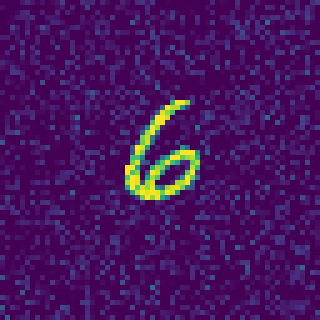

In [ ]:
from IPython.display import clear_output
pbar = tqdm(range(10001))
for i in pbar:
    batch = next(gen)
    loss = optim_step(target_nca, batch, optim, device)
    pbar.set_description(f"Loss: {loss:.10f}")
    history.append(loss.item())
    
    if i % 200 == 0:
        clear_output(wait=True)
        display(pbar.container)
        plt.plot(history)
        plt.yscale("log")
        plt.show()

        x, y = batch
        x = x.to(device)
        y = y.to(device)
        out = target_nca(x, steps=80)
        display(make_gif(out[0,:,0], size=(64 * 5, 64 * 5), fps=20))
        display(make_gif(out[1,:,0], size=(64 * 5, 64 * 5), fps=20))

In [ ]:
plt.plot(history)

In [ ]:
with open("nca-save.pkl", "wb+") as fp:
    torch.save(target_nca, fp)

In [ ]:
x, y = batch
x = x.to(device)
y = y.to(device)
out = target_nca(x, steps=40)

In [ ]:
display(make_gif(out[0,:,0], size=(40 * 5, 32 * 5)))
display(make_gif(out[1,:,0], size=(40 * 5, 32 * 5)))
display(make_gif(out[2,:,0], size=(40 * 5, 32 * 5)))
display(make_gif(out[3,:,0], size=(40 * 5, 32 * 5)))
display(make_gif(out[4,:,0], size=(40 * 5, 32 * 5)))

In [ ]:
f = -1
b = 2
out = out.detach().cpu()
bs, L, _, H, W = out.shape
im = out[b, f, 0]

vals0 = out[b, :f, 0][:, screen == 1].mean(axis=-1)
vals1 = out[b, :f, 0][:, screen == 2].mean(axis=-1)
vals2 = out[b, :f, 0][:, screen == 3].mean(axis=-1)

bar_val0 = out[b, f, 0][screen == 1].mean(axis=-1)
bar_val1 = out[b, f, 0][screen == 2].mean(axis=-1)
bar_val2 = out[b, f, 0][screen == 3].mean(axis=-1)
bar_vals = torch.stack([bar_val0, bar_val1, bar_val2]).softmax(0)

fig, axs = plt.subplots(1, 4, figsize=(8, 6), dpi=120)
axs[0].imshow(out[b, 0, 0])
axs[0].axis("off")
axs[1].imshow(im)

axs[1].contour(screen == 1, colors="tab:red", linewidths=3, alpha=0.8)
axs[1].contour(screen == 2, colors="tab:green", linewidths=3, alpha=0.8)
axs[1].contour(screen == 3, colors="tab:blue", linewidths=3, alpha=0.8)
axs[1].axis("off")

axs[2].plot(vals0, c="tab:red")
axs[2].plot(vals1, c="tab:green")
axs[2].plot(vals2, c="tab:blue")
axs[2].set_aspect(15)
axs[2].set_xlim(0, L)
axs[2].set_ylim(-1, 1)

axs[3].bar([0, 1, 2], bar_vals, color=["tab:red", "tab:green", "tab:blue"])
axs[3].set_aspect(2)
axs[3].set_ylim(0, 1)

plt.tight_layout()

In [ ]:
def plot_fun(out, frame_id=-1, batch_id=0):
    f = frame_id
    b = batch_id
    out = out.detach().cpu()
    bs, L, _, H, W = out.shape
    im = out[b, f, 0]

    vals0 = out[b, :f, 0][:, screen == 1].mean(axis=-1)
    vals1 = out[b, :f, 0][:, screen == 2].mean(axis=-1)
    vals2 = out[b, :f, 0][:, screen == 3].mean(axis=-1)

    bar_val0 = out[b, f, 0][screen == 1].mean(axis=-1)
    bar_val1 = out[b, f, 0][screen == 2].mean(axis=-1)
    bar_val2 = out[b, f, 0][screen == 3].mean(axis=-1)
    bar_vals = torch.stack([bar_val0, bar_val1, bar_val2]).softmax(0)

    fig, axs = plt.subplots(1, 4, figsize=(16, 12), dpi=120)
    axs[0].imshow(out[b, 0, 0])
    axs[0].axis("off")
    axs[1].imshow(im)

    axs[1].contour(screen == 1, colors="tab:red", linewidths=3, alpha=0.8)
    axs[1].contour(screen == 2, colors="tab:green", linewidths=3, alpha=0.8)
    axs[1].contour(screen == 3, colors="tab:blue", linewidths=3, alpha=0.8)
    axs[1].axis("off")

    axs[2].plot(vals0, c="tab:red")
    axs[2].plot(vals1, c="tab:green")
    axs[2].plot(vals2, c="tab:blue")
    axs[2].set_aspect(15)
    axs[2].set_xlim(0, L)
    axs[2].set_ylim(-1, 1)

    axs[3].bar([0, 1, 2], bar_vals, color=["tab:red", "tab:green", "tab:blue"])
    axs[3].set_aspect(2)
    axs[3].set_ylim(0, 1)

    plt.tight_layout()
    plt.close()
    return fig

In [ ]:
L = out.shape[1]
figs0 = [plot_fun(out, i, 0) for i in tqdm(range(0, L))]
figs1 = [plot_fun(out, i, 2) for i in tqdm(range(0, L))]
figs2 = [plot_fun(out, i, 1) for i in tqdm(range(0, L))]

In [ ]:
pils0 = [fig2img(f) for f in tqdm(figs0)]
pils1 = [fig2img(f) for f in tqdm(figs1)]
pils2 = [fig2img(f) for f in tqdm(figs2)]

In [ ]:
pils00 = pils0[0], pils0[20], pils0[-1]
pils11 = pils1[0], pils1[20], pils1[-1]
pils22 = pils2[0], pils2[20], pils2[-1]

In [ ]:
arrs0 = [np.array(p) for p in pils00]
arrs1 = [np.array(p) for p in pils11]
arrs2 = [np.array(p) for p in pils22]

In [ ]:
# Image.fromarray(np.concatenate(arrs2, axis=0))

In [ ]:
cat_pils = [
    Image.fromarray(np.concatenate(
        [np.array(p0), np.array(p1), np.array(p2)], axis=0
    )) for p0, p1, p2 in zip(pils0, pils1, pils2)
]

In [ ]:
# cat_pils

In [ ]:
gif_from_pils(cat_pils, fps=30)